In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
import random
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.models as models

In [2]:
# CutPaste function for synthetic anomaly creation
def cut_paste(source, destination, mask):
    try:
        # Ensure dimensions match
        if source.shape != destination.shape or source.shape[:2] != mask.shape[:2]:
            raise ValueError("Source, destination, and mask dimensions must match.")
        if np.sum(mask) == 0:
            raise ValueError("Mask is empty, skipping CutPaste operation.")
        
        # Find the bounding box of the mask
        y_indices, x_indices = np.where(mask > 0)
        top_left = (min(x_indices), min(y_indices))
        bottom_right = (max(x_indices), max(y_indices))

        # Extract the patch from the source image
        patch = source[top_left[1]:bottom_right[1] + 1, top_left[0]:bottom_right[0] + 1]
        patch_h, patch_w, _ = patch.shape

        # Randomly select a position on the destination image to paste the patch
        dest_h, dest_w, _ = destination.shape
        max_y = dest_h - patch_h
        max_x = dest_w - patch_w

        if max_y <= 0 or max_x <= 0:
            raise ValueError("Patch size is too large to fit in the destination image.")

        paste_top_left = (random.randint(0, max_x), random.randint(0, max_y))
        destination[paste_top_left[1]:paste_top_left[1] + patch_h, paste_top_left[0]:paste_top_left[0] + patch_w] = patch
    except ValueError as e:
        print(f"Error during CutPaste: {e}. Using the original destination image.")
    return destination

In [3]:
# Custom Dataset class with CutPaste for synthetic anomalies
class MVTecNSADataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        for root, _, files in os.walk(os.path.join(root_dir, split)):
            for fname in files:
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, fname))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            raise IndexError("Index out of range for dataset.")
        
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image at path {img_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
        # Apply CutPaste to create synthetic anomalies
        if self.split == "train":
            source_idx = random.randint(0, len(self.image_paths) - 1)
            source_img_path = self.image_paths[source_idx]
            source_image = cv2.imread(source_img_path)
            if source_image is None:
                raise ValueError(f"Source image at path {source_img_path} could not be loaded.")
            source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
            source_image = cv2.resize(source_image, (256, 256))

            mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
            h, w = mask.shape
            top_left = (random.randint(0, w // 2), random.randint(0, h // 2))
            bottom_right = (random.randint(w // 2, w), random.randint(h // 2, h))
            mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 255

            # Ensure mask is valid and perform CutPaste
            image = cut_paste(source_image, image, mask)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        return image, 0  # Label 0 for normal data

In [4]:
# Visualize dataset samples
def visualize_dataset_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        try:
            image, _ = dataset[i]
            image = image.permute(1, 2, 0).numpy()
            axes[i].imshow(image)
            axes[i].axis('off')
        except (ValueError, IndexError) as e:
            print(e)
            continue
    plt.show()

Total number of images in the dataset: 209


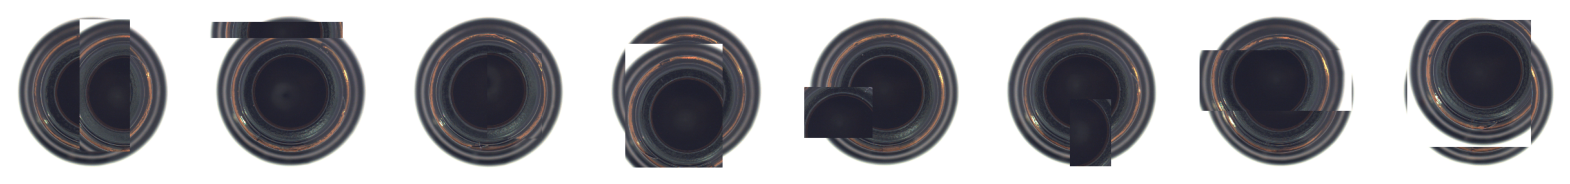

In [5]:
# Prints the total number of images in the dataset and visualizes 8 samples

def analyze_dataset(dataset):
    num_images = len(dataset)
    print(f"Total number of images in the dataset: {num_images}")
    
    # Visualize some samples
    visualize_dataset_samples(dataset, num_samples=8)

# Analyze and visualize the training dataset
analyze_dataset(MVTecNSADataset("./datasets/mvtec/bottle/", split="train"))

In [6]:
# Model class: ResNet Encoder-Decoder with TransposeBasicBlock
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        # Perform upsampling path
        upsampled = self.upsample(x)

        return self.relu(out + upsampled)

class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()

        # Encoder: Using ResNet layers up to layer4
        resnet = models.resnet18(pretrained=True)
        
        # Encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # NIN layer (512 -> 256 -> 128)
        self.nin = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

        # Decoder (TransposeBasicBlock layers)
        self.uplayer1 = TransposeBasicBlock(128, 64)
        self.uplayer2 = TransposeBasicBlock(64, 32)
        self.uplayer3 = TransposeBasicBlock(32, 16)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear')

        # Final conv layer
        self.convtranspose1 = nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

        # Final activation (Identity in this case)
        self.final_activation = nn.Identity()

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # NIN Layer
        x = self.nin(x)

        # Decoder layers
        x = self.uplayer1(x)
        x = self.uplayer2(x)
        x = self.uplayer3(x)

        # Upsample
        x = self.upsample(x)

        # Final convolution
        x = self.convtranspose1(x)

        # Final activation (here it's Identity)
        x = self.final_activation(x)

        return x


In [7]:
wandb.init(project="nsa-mvtec", entity="sameerhashmi1995")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995. Use `wandb login --relogin` to force relogin


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
data_dir = "./datasets/mvtec/bottle/" 
train_dataset = MVTecNSADataset(data_dir, split="train")
val_dataset = MVTecNSADataset(data_dir, split="test")


In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [11]:
model = ResNetEncDec()
model = model.to(device)

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


In [13]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # Print shapes for debugging
        print(f"Input shape: {images.shape}, Output shape: {outputs.shape}")
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [14]:
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    return total_loss / len(loader)


In [15]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validation
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss
        })
        
        # Save the model checkpoint if it's the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "./cutpaste_checkpoints/best_resnet_encdec.pth")
        
        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [16]:
train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50)

Epoch [1/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:02<00:11,  1.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:04,  2.46it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  43%|████▎     | 6/14 [00:02<00:02,  3.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  4.99it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  3.53it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.83it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.55it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.6354, Val Loss: 0.4424
Epoch [2/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.36s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.40it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.58it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.78it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.4648, Val Loss: 0.4458
Epoch [3/50]


Training:   7%|▋         | 1/14 [00:01<00:16,  1.24s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.58it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.72it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  4.09it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  3.17it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.3854, Val Loss: 0.4042
Epoch [4/50]


Training:   7%|▋         | 1/14 [00:01<00:15,  1.20s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.63it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.93it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  3.19it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.55it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.3221, Val Loss: 0.3178
Epoch [5/50]


Training:   7%|▋         | 1/14 [00:01<00:15,  1.16s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.63it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.46it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.87it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  3.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.44it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.2327, Val Loss: 0.2077
Epoch [6/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.32s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.44it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.33it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.71it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.93it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.28it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.1462, Val Loss: 0.1206
Epoch [7/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.36s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.49it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  71%|███████▏  | 10/14 [00:04<00:01,  2.89it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  86%|████████▌ | 12/14 [00:04<00:00,  4.05it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  2.89it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0900, Val Loss: 0.0727
Epoch [8/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.50s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.25it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.54it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.87it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.13it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  2.89it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0605, Val Loss: 0.0486
Epoch [9/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Error during CutPaste: Patch size is too large to fit in the destination image.. Using the original destination image.


Training:   7%|▋         | 1/14 [00:01<00:18,  1.44s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.27it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.26it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.54it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.70it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0447, Val Loss: 0.0357
Epoch [10/50]


Training:   7%|▋         | 1/14 [00:01<00:16,  1.29s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.46it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.26it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.53it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.55it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.78it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.25it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0358, Val Loss: 0.0290
Epoch [11/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.33s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.38it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.55it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.67it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0313, Val Loss: 0.0251
Epoch [12/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.50s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.47it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.26it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.48it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0289, Val Loss: 0.0235
Epoch [13/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.49s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.30it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.70it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  4.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  3.71it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  5.10it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0275, Val Loss: 0.0213
Epoch [14/50]


Training:   7%|▋         | 1/14 [00:00<00:12,  1.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:03,  2.93it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:01<00:02,  3.21it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  4.48it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:02<00:01,  3.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.74it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:03<00:00,  3.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0262, Val Loss: 0.0203
Epoch [15/50]


Training:   7%|▋         | 1/14 [00:01<00:16,  1.27s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.46it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.41it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.70it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  3.04it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0234, Val Loss: 0.0193
Epoch [16/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.47s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.17it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.53it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.82it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0228, Val Loss: 0.0182
Epoch [17/50]


Training:   7%|▋         | 1/14 [00:01<00:15,  1.22s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.51it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.22it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0226, Val Loss: 0.0173
Epoch [18/50]


Training:   7%|▋         | 1/14 [00:01<00:14,  1.15s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.08it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.33it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0212, Val Loss: 0.0166
Epoch [19/50]


Training:   7%|▋         | 1/14 [00:01<00:14,  1.12s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.67it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.37it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.68it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.83it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0212, Val Loss: 0.0160
Epoch [20/50]


Training:   7%|▋         | 1/14 [00:01<00:14,  1.13s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.44it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.75it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.07it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0188, Val Loss: 0.0156
Epoch [21/50]


Training:   7%|▋         | 1/14 [00:01<00:14,  1.11s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.66it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.48it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.78it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0186, Val Loss: 0.0152
Epoch [22/50]


Training:   7%|▋         | 1/14 [00:01<00:14,  1.12s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  4.12it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:02<00:01,  4.67it/s]

Error during CutPaste: Mask is empty, skipping CutPaste operation.. Using the original destination image.


Training:  64%|██████▍   | 9/14 [00:03<00:01,  3.19it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  4.32it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:03<00:00,  3.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0183, Val Loss: 0.0145
Epoch [23/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.50s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.13it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.47it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.56it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.98it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0176, Val Loss: 0.0143
Epoch [24/50]


Training:   7%|▋         | 1/14 [00:01<00:18,  1.45s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.18it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.20it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.41it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.43it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.49it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  2.91it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0175, Val Loss: 0.0138
Epoch [25/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.52s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.19it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.47it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.38it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0169, Val Loss: 0.0134
Epoch [26/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.50s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.14it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.18it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.38it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.47it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.62it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.27it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0184, Val Loss: 0.0133
Epoch [27/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.53s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.12it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.99it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.20it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.28it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.93it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0164, Val Loss: 0.0129
Epoch [28/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.72s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:04,  1.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.34it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.49it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.20it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0166, Val Loss: 0.0127
Epoch [29/50]


Training:   7%|▋         | 1/14 [00:01<00:18,  1.43s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.12it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.32it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.40it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.53it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.01it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0161, Val Loss: 0.0124
Epoch [30/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.57s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.08it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.99it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.20it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.47it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.64it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0159, Val Loss: 0.0122
Epoch [31/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.33s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.30it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.52it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.56it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.74it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0151, Val Loss: 0.0119
Epoch [32/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.56s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.08it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.26it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.38it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.33it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0150, Val Loss: 0.0116
Epoch [33/50]


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Error during CutPaste: Mask is empty, skipping CutPaste operation.. Using the original destination image.


Training:   7%|▋         | 1/14 [00:01<00:17,  1.37s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.29it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.31it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.51it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.31it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0145, Val Loss: 0.0117
Epoch [34/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.32s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:01<00:07,  1.51it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:01<00:03,  3.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.03it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.57it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.71it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.28it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0147, Val Loss: 0.0112
Epoch [35/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.94it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.75it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.86it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.39it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.36it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0139, Val Loss: 0.0109
Epoch [36/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.53s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.12it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.88it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  43%|████▎     | 6/14 [00:03<00:03,  2.31it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  57%|█████▋    | 8/14 [00:03<00:01,  3.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.12it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.25it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.21it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0134, Val Loss: 0.0107
Epoch [37/50]


Training:   7%|▋         | 1/14 [00:01<00:18,  1.46s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.16it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.82it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.31it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.76it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0143, Val Loss: 0.0106
Epoch [38/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.49s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.10it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.30it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.25it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.37it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.05it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0135, Val Loss: 0.0103
Epoch [39/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.59s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.09it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.83it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.02it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.34it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.48it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0127, Val Loss: 0.0103
Epoch [40/50]


Training:   7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.01it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:03,  2.62it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:04,  1.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.06it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.17it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.79it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0128, Val Loss: 0.0099
Epoch [41/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.47s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.13it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.69it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.73it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.00it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.14it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0118, Val Loss: 0.0097
Epoch [42/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.72s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:05,  1.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.59it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.65it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.23it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.01it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0119, Val Loss: 0.0096
Epoch [43/50]


Training:   7%|▋         | 1/14 [00:01<00:24,  1.90s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  14%|█▍        | 2/14 [00:02<00:10,  1.11it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:04,  2.41it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.56it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.61it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.96it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:00,  3.05it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:06<00:00,  2.28it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0123, Val Loss: 0.0094
Epoch [44/50]


Training:   7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:06,  1.81it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  29%|██▊       | 4/14 [00:02<00:04,  2.44it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.79it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  1.95it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:05<00:01,  2.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  2.45it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0116, Val Loss: 0.0095
Epoch [45/50]


Training:   7%|▋         | 1/14 [00:01<00:20,  1.59s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.07it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  1.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.01it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.35it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.34it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0117, Val Loss: 0.0094
Epoch [46/50]


Training:   7%|▋         | 1/14 [00:01<00:24,  1.86s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:02<00:06,  1.83it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:03<00:05,  1.76it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  2.92it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:01,  2.51it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.70it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:05<00:00,  3.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0119, Val Loss: 0.0091
Epoch [47/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.52s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.14it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.15it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.36it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:04<00:02,  2.26it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.37it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.14it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0114, Val Loss: 0.0091
Epoch [48/50]


Training:   7%|▋         | 1/14 [00:01<00:19,  1.46s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:05,  2.18it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.03it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:03<00:02,  3.24it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.58it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:04<00:00,  3.79it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.51it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0117, Val Loss: 0.0091
Epoch [49/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.31s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.29it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:03,  2.34it/s]

Error during CutPaste: Mask is empty, skipping CutPaste operation.. Using the original destination image.
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:01,  3.59it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.68it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.85it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  93%|█████████▎| 13/14 [00:04<00:00,  3.46it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0109, Val Loss: 0.0087
Epoch [50/50]


Training:   7%|▋         | 1/14 [00:01<00:17,  1.38s/it]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  21%|██▏       | 3/14 [00:01<00:04,  2.28it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  36%|███▌      | 5/14 [00:02<00:04,  2.18it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  50%|█████     | 7/14 [00:02<00:02,  3.43it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  64%|██████▍   | 9/14 [00:03<00:01,  2.77it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Training:  79%|███████▊  | 11/14 [00:03<00:00,  3.97it/s]

Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])


Input shape: torch.Size([16, 3, 256, 256]), Output shape: torch.Size([16, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256]), Output shape: torch.Size([1, 3, 256, 256])


Train Loss: 0.0111, Val Loss: 0.0085


In [17]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.01108
val_loss,0.00851


In [19]:
# Plot some validation results
model.load_state_dict(torch.load("./cutpaste_checkpoints/best_resnet_encdec.pth"))
model.eval()

ResNetEncDec(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [20]:
val_iter = iter(val_loader)
images, _ = next(val_iter)
images = images.to(device)

In [21]:
val_iter = iter(val_loader)
images, _ = next(val_iter)
images = images.to(device)


In [22]:
with torch.no_grad():
    reconstructions = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047753926..1.4182571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03270977..1.4101022].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03435056..1.4176195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05326948..1.4215705].


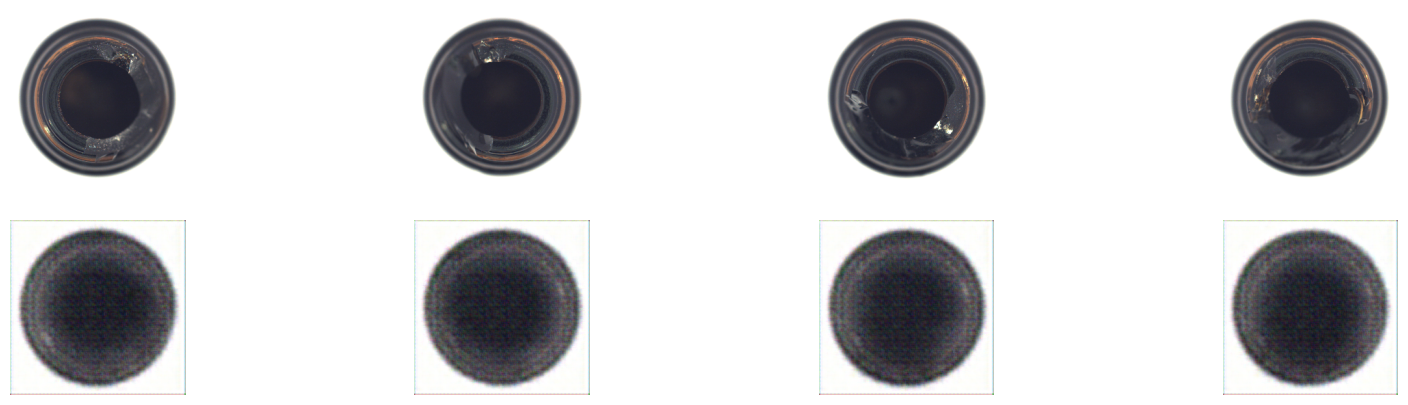

In [24]:
# Plot original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(20, 5))
for i in range(4):
    axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructions[i].cpu().permute(1, 2, 0))
    axes[1, i].axis('off')
plt.show()